### Edgar Moises Hernandez-Gonzalez
#### Advisors: Pilar Gomez-Gil, Erik Bojorges-Valdez
#### National Institute of Optical and Electronic Astrophysics (INAOE)
#### 11/24/20-12/03/20
#### Thesis: Classification of EEG signals based on two-dimensional representations and convolutional neural networks
#### EEG classification with CNN-2D or CNN-2D + LSTM
##### Characteristics = STFT Spectrograms or CWT Scalograms

##### Training and evaluation of CNN-2D or CNN-2D + LSTM with STFT or CWT
##### 5 independent runs

In [118]:
# activate google drive
# not necessary if running locally

# from google.colab import drive

In [119]:

# mount drive
# not necessary if running locally


# drive.mount('/content/drive')

In [120]:
# run from here if running on your local computer, import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [121]:

# for this script to work it must say 'channels_last'
# if it says 'channels_first' it doesn't work
K.image_data_format()

'channels_last'

In [157]:
# read .csv with train and test data
# the path must be specified
# header = None means that the .csv files have no header
patien_num = "1"
x_train = pd.read_csv("Preprocessed_data/MI-EEG-B"+patien_num+"T.csv",
                      header=None)
x_test = pd.read_csv("Preprocessed_data/MI-EEG-B"+patien_num+"E.csv",
                     header=None)
y_train = pd.read_csv("Preprocessed_data/etiquetas_train_"+patien_num+".csv",
                      header=None)
y_test = pd.read_csv("Preprocessed_data/etiquetas_test_"+patien_num+".csv",
                     header=None)
n_classes = len(np.unique(y_test))

In [158]:

# print the shape of the data arrays
# x_train and x_test are matrices where the rows are the number of examples
# and the columns are the number of seconds times the sampling rate
# for the number of channels
# y_train and y_test are the labels
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [159]:
# calculate the number of samples
# if you do not have the y_test you can use the x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 400
n_samples_test : 320


In [160]:
# calculate the number of classes
# this could be calculated like this n_classes = len(np.unique(y))
# the y can be train or test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [178]:
# calculate spectrograms with STFT
# vertical concatenation of the spectrograms of the n channels
# join_vertical_spectrograms(x_train or x_test matrix,
# sample rate, height, width, n_channels, signal segment size,
# overlapping points to calculate STFT)
def join_vertical_spectrograms(data, fs, alto, ancho, n_canales, pts_sig,
                                 pts_superpuestos):

  #fs = fs #sample rate
  # create 3D matrix to store all the images of the STFT pts_overlapping):
  datas = np.zeros((data.shape[0],alto, ancho))
  
  # create 2D matrix where each STFT image will be saved
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n samples
    for j in range(n_canales): # n channels
      
      # sig_points = signal duration in seconds x sampling rate
      # for a 2 sec signal with 250 Hz fs, sig_points = 500
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      # spectrogram with STFT
        # sign,
        # fs=sampling frequency,
        # window='window type',
        # nperseg=window size,
        # noverlap=overlapping points,
        # nfft=size of the FFT with zero padding, If=None the length of the FFT is nperseg
        # scaling='density': power spectral density, 'spectrum': power spectrum
      f, t, Sxx = spectrogram(sig, fs=fs, window='hann', nperseg=fs,
                              noverlap=pts_superpuestos, nfft=fs*2,
                              scaling='spectrum')
      
      # vertical concatenation of channels
      # spectrogram generates 45 rows (frequencies from 8 to 30Hz with steps of
      #0.5Hz) and 31 columns (time)
      # the frequencies from 8 to 30 Hz are between the indices of 16 to 60
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]

    datas[i] = temporal
    if i % 100 == 0: # this is to see how it progresses
      print(i)
  return datas

In [179]:
# calculate scalograms with CWT
# vertical concatenation of the scalograms of the n channels
# join_vertical_scalograms(x_train or x_test matrix, sample rate,
# height, width, n_channels, signal segment size):
def join_vertical_scalograms(data, fs, high, width, n_canales, pts_sig):
  # width and height, for resize using Open CV
  dim = (int(np.floor(width/2)), int(np.floor(high/2))) # width heigth
  
  # calculate scales for complex Morlet wavelet 3-3
  # with frequencies from 8 to 30 Hz with steps of 0.5 Hz
  scales = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  
  # create 3D array to store all images
  datas = np.zeros((data.shape[0], int(np.floor(high/2)),
                    int(np.floor(width/2))))
  
  # create 2D matrix where each image will be saved
  temp = np.zeros((high, width))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales
      
      # sig_points = signal duration in seconds x sampling rate
      # for a 2 sec signal with 250 Hz fs, sig_points = 500
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      
       # scalogram with CWT
        # sign
        # scales
        # name of the wavelet, in this case Morlet complex 3-3
        # sampling period = 1 / sampling rate
      coef, freqs = pywt.cwt(sig, scales, 'cmor3-3',
                             sampling_period = (1 / fs))
      
      # vertical concatenation of channels
      # spectrogram generates 45 rows (frequencies from 8 to 30Hz with steps of
      #0.5Hz) and 31 columns (time)
      # since cmor3-3 generates complex numbers, calculate the module
      temp[j*45:(j+1)*45, :] = abs(coef)

    
    # resize using interarea interpolation with OpenCV
    resized = cv2.resize(temp, dim, interpolation=cv2.INTER_AREA)
    datas[i] = resized
    if i % 100 == 0: # this is just to see how it progresses
      print(i)
  return datas




In [162]:
# select STFT or CWT
start = time.time()

# STFT, call join_vertical_spectrograms(data, fs, height, width,
#n_channels, next_pts, overlapping_pts))
# uncomment the next two lines for STFT


x_train = join_vertical_spectrograms(x_train, 250, 135, 31, 3, 1000, 225)
x_test = join_vertical_spectrograms(x_test, 250, 135, 31, 3, 1000, 225)



# CWT, call join_vertical_scalograms(data, fs, height, width,
# n_channels, next_pts)
# uncomment the next two lines for CWT
# x_train = join_vertical_scalograms(x_train, 250, 135, 1000, 3, 1000)
# x_test = join_vertical_scalograms(x_test, 250, 135, 1000, 3, 1000)

end = time.time()
print("Time:", end - start)

0
100
200
300
0
100
200
300
Time: 0.4265918731689453


In [163]:
# shape of spectrograms (STFT) or scalograms (CWT)
# the shape must be three-dimensional
# the first dimension is equal to the number of examples
# the second dimension is the height of the images calculated with STFT or CWT
# the third dimension is the width of the images calculated with STFT or CWT
print(x_train.shape)
print(x_test.shape)

(400, 135, 31)
(320, 135, 31)


In [164]:
# print the maximum, minimum and average of x_train and x_test
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

9.261731528690847
5.969333558701494
2.2017676103519343e-07
1.6913747408199134e-08
0.1062383202435291
0.07730779842532526


In [165]:
# round the maximum of x_train to the ceiling
x = np.ceil(np.max(x_train))
print(x)

10.0


In [167]:

# print the maximum, minimum and average of x_train and x_test
# after normalizing the data
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9261731
0.59693336
2.2017677e-08
1.6913747e-09
0.010623828
0.0077307806


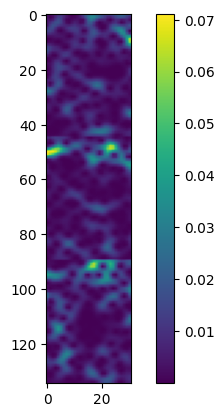

In [168]:
# show x_train example 2
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

In [56]:
# select reshape to 4D (for CNN-2D) or 5D (for CNN-2D + LSTM)
# for CNN-2D use 4D, for CNN-2D + LSTM use 5D

# convert from 3D to 4D (CNN-2D)
# uncomment the following two lines to use CNN-2D
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# convert from 3D to 5D (CNN-2D + LSTM)
# uncomment the next two lines to use CNN-2D + LSTM
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

# print the form
print(x_train.shape)
print(x_test.shape)

(400, 1, 67, 500, 1)
(320, 1, 67, 500, 1)


In [57]:

# uncomment to save the model
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2b/Modelos/STFT_CNN_09.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [58]:
# create CNN-2D neural network
# the number of filters, the size of the filters must be specified
# and the number of neurons in the hidden layer of the MLP (Dense)
# 2D convolutional two-layer sequential model with relu activation and
# zero padding and 2x2 max pooling
# flatten the feature maps to convert them from a 3D matrix to
# a 1D vector
# MLP of a hidden layer with relu
# regularization with dropout of 0.5
# the last layer uses a softmax function to obtain a distribution
# of probability
#Adam optimizer with 1x10-4 learning rate
# the loss function is the categorical cross entropy
# (sparse is used to avoid converting the tags to one hot)
# the metric to evaluate is the accuracy
def CNN_2D(n_filtros, tamano_filtros, n_neuronas):
  model = Sequential()
  model.add(Conv2D(n_filtros, tamano_filtros, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(n_filtros, tamano_filtros, activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [59]:
# create neural network CNN-2D + LSTM
# you must specify the number of filters, the size of the filters,
# the number of neurons in the hidden layer of the MLP (Dense) and the number of
# LSTM units 
# 2D convolutional two-layer sequential model with relu activation and
# zero padding and 2x2 max pooling
# flatten the feature maps to convert them from a 3D matrix to
# a 1D vector
# LSTM recurrent network with hyperbolic tangent activation and dropout of 0.5
# (this goes between the convolutional layers and the MLP)
# MLP of a hidden layer with relu
# regularization with dropout of 0.5
# the last layer uses a softmax function to obtain a distribution
# of probability
#Adam optimizer with 1x10-4 learning rate
# the loss function is the categorical cross entropy
# (sparse is used to avoid converting the tags to one hot)
# the metric to evaluate is the accuracy
# in order to connect CNN-2D with LSTM the TimeDistributed layer must be used
def CNN_2D_LSTM_TD(n_filtros, tamano_filtros, n_neuronas, unidades_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(unidades_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.6880077123641968
accuracy:  0.78125
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
kappa:  0.5625
confusion matrix:
 [[134  26]
 [ 44 116]]


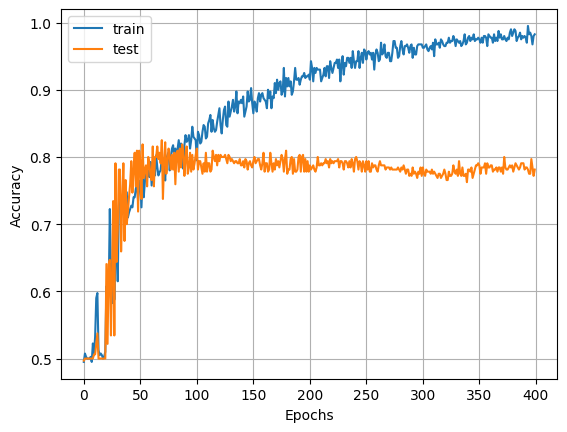

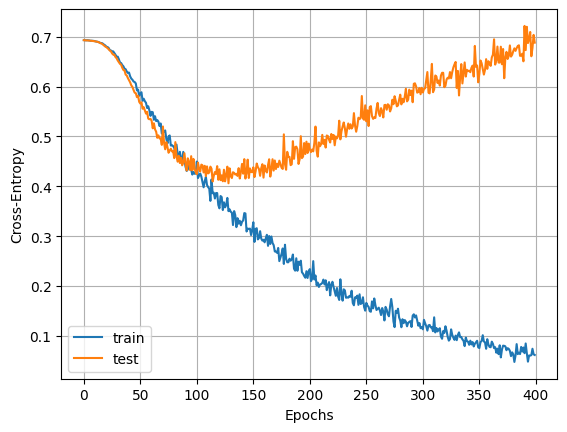

Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.707082211971283
accuracy:  0.7562500238418579
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
kappa:  0.5125
confusion matrix:
 [[126  34]
 [ 44 116]]


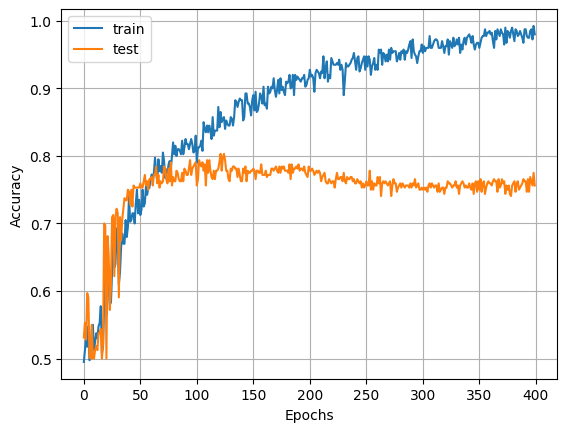

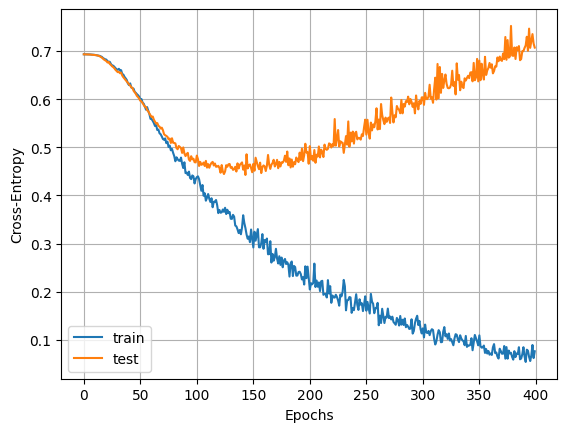

Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.6955258250236511
accuracy:  0.7749999761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
kappa:  0.55
confusion matrix:
 [[136  24]
 [ 48 112]]


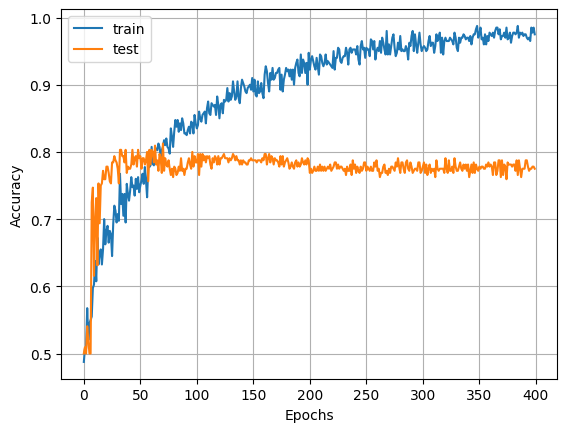

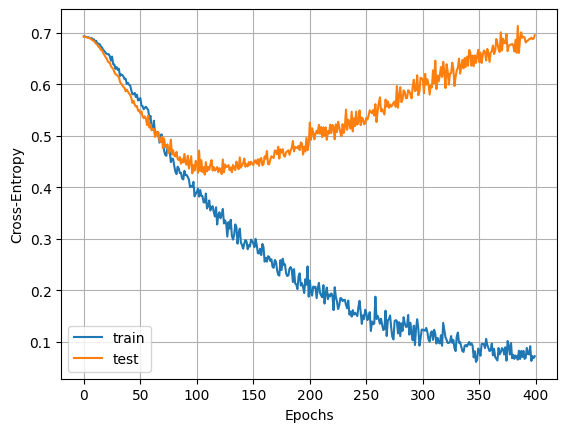

Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7374672889709473
accuracy:  0.7593749761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
kappa:  0.51875
confusion matrix:
 [[137  23]
 [ 54 106]]


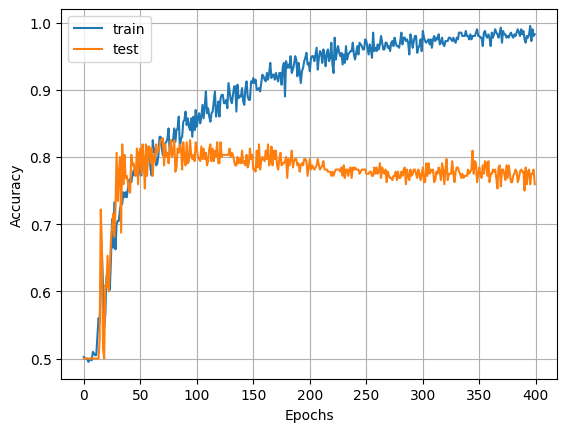

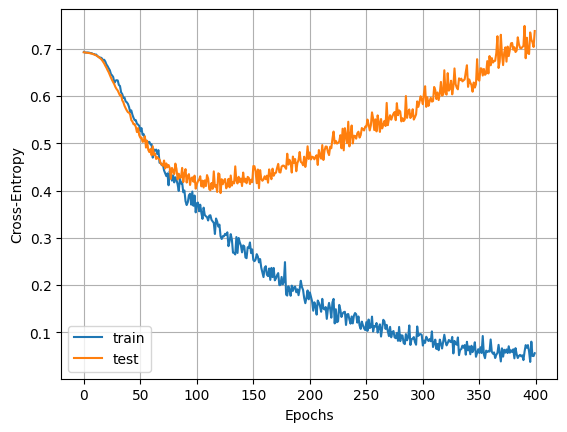

Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.5550025701522827
accuracy:  0.796875
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
kappa:  0.59375
confusion matrix:
 [[127  33]
 [ 32 128]]


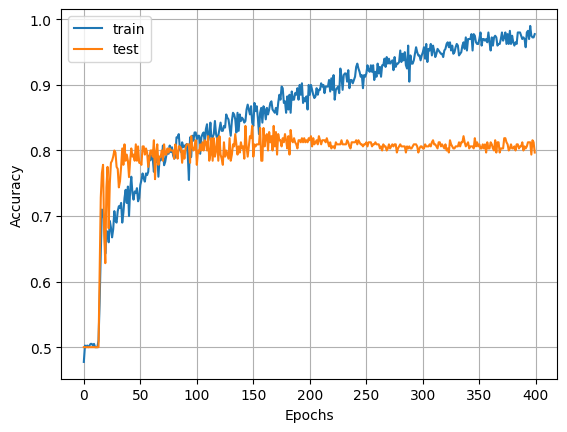

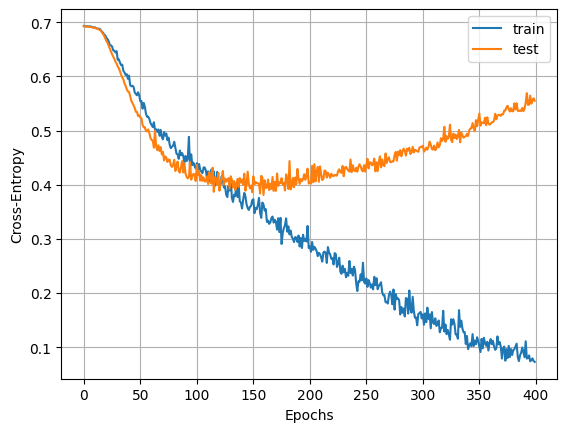


Resultados:
loss: [0.6880077123641968, 0.707082211971283, 0.6955258250236511, 0.7374672889709473, 0.5550025701522827]
accuracy: [0.78125, 0.7562500238418579, 0.7749999761581421, 0.7593749761581421, 0.796875]
kappa: [0.5625, 0.5125, 0.55, 0.51875, 0.59375]
Tiempo: 298.81301379203796


In [60]:
start = time.time()
array_loss = [] # array for losses
array_acc = [] # array for accuracy
array_kappa = [] # array for kappas
number_of_epochs = 5
x = np.ceil(np.max(x_train))
# convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# scale the values ​​in a range from 0 to 1 (normalize)
# divide by the maximum rounded to the ceiling
x_train /= x
x_test /= x
for i in range(number_of_epochs): # number of executions
  print("Iteration:", i+1)
    
  # select the neural network
  #model = CNN_2D(4, (3,3), 32)
  model = CNN_2D_LSTM_TD(4, (3,3), 32, 4)

  # train neural network
    # for STFT = 400 epochs, for CWT = 100 epochs
    # batch_size: its size is optional (depends on the dataset)
    # x_train: array
    # y_train: tags
    # epochs: number of epochs
    # batch_size: batch size (the smaller the batch, the longer the training takes)
    # validation_data: this data is to evaluate the network at each epoch, that is
      # It is important to mention that this data is not used to train the
      # network are only to evaluate in each epoch
    # verbose: 0 to not print the training process, other options
      # can be 1 or 2
  # callbacks: save the model at each epoch and replace only if it is better
    #the previous
  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
                      #,callbacks=[mc]) # uncomment to save the model
    

  # evaluate neural network with x_test and y_test
  # (data that was never presented to the network in training)
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss) # add test_loss to array_loss array
  print("loss: ", test_loss)
  array_acc.append(test_acc) # add test_acc to array_acc array
  print("accuracy: ", test_acc)
    

  # predict x_test (probability distribution)
  probabilities = model.predict(x_test)
  
  
  # obtain the predicted labels by calculating the index of the maximum
  # of the probability distribution
  y_pred = np.argmax(probabilities, 1) # 1 = fila
    
  
  # calculate Cohen's kappa
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa) # add test_acc to array_acc array
  print("kappa: ", kappa)
  
  
  #calculate confusion matrix
  confusion_matrix_table = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", confusion_matrix_table)
    
  
  # graph of the behavior of accuracy and loss in each epoch
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
total_time = fin - start
print("Time took:", total_time)

In [61]:
# model summary (neural network)
# the shape of the output of each layer is shown and
# the number of parameters to learn in each layer
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_24             │ (None, 1, 67, 500, 4)  │            40 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 1, 33, 250, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 1, 33, 250, 4)  │           148 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 1, 16, 125, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 1, 8000)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4)              │       128,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385,484 (1.47 MB)

 Trainable params: 128,494 (501.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,990 (1003.87 KB)

In [62]:
# print mean, standard deviation and maximum of accuracy and kappa
# and the time of the 5 independent executions
print()
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7737
std: (+/- 0.0149)
Mean Kappa: 0.5475
std: (+/- 0.0297)
Max Accuracy: 0.7969
Max Kappa: 0.5938
Tiempo: 298


In [63]:
# GPU information
# only use if you are using Google Colab GPU

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

Thu Jul 25 19:58:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   25C    P8             37W /  370W |    2849MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [189]:
patien_num = "1"
patients = [1,2,3,4,5,6,7,8,9]
for i in patients:
    print("Starting patient num "+ str(patients[i-1]))

    x_train = pd.read_csv("Preprocessed_data/MI-EEG-B"+str(patients[i-1])+"T.csv",
                        header=None)
    x_test = pd.read_csv("Preprocessed_data/MI-EEG-B"+str(patients[i-1])+"E.csv",
                        header=None)
    y_train = pd.read_csv("Preprocessed_data/labels_train_"+str(patients[i-1])+".csv",
                        header=None)
    y_test = pd.read_csv("Preprocessed_data/labels_test_"+str(patients[i-1])+".csv",
                        header=None)
    n_classes = len(np.unique(y_test))
    
    

    #CWT
    # x_train = join_vertical_scalograms(x_train, 250, 135, 1000, 3, 1000)
    # x_test = join_vertical_scalograms(x_test, 250, 135, 1000, 3, 1000)
    #STFT
    x_train = join_vertical_spectrograms(x_train, 250, 135, 31, 3, 1000, 225)
    x_test = join_vertical_spectrograms(x_test, 250, 135, 31, 3, 1000, 225)

    #CNN 2D
    # x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
    # x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

    #+LSTM
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

    start = time.time()
    array_loss = [] # array for losses
    array_acc = [] # array for accuracy
    array_kappa = [] # array for kappas
    number_of_epochs = 5
    x = np.ceil(np.max(x_train))
    # convert to float
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # scale the values ​​in a range from 0 to 1 (normalize)
    # divide by the maximum rounded to the ceiling
    x_train /= x
    x_test /= x
    for j in range(number_of_epochs): # number of executions
        print("Iteration:", j+1)
            
        # select the neural network
        # model = CNN_2D(4, (3,3), 32)
        model = CNN_2D_LSTM_TD(4, (3,3), 32, 4)

        # train neural network
            # for STFT = 400 epochs, for CWT = 100 epochs
            # batch_size: its size is optional (depends on the dataset)
            # x_train: array
            # y_train: tags
            # epochs: number of epochs
            # batch_size: batch size (the smaller the batch, the longer the training takes)
            # validation_data: this data is to evaluate the network at each epoch, that is
            # It is important to mention that this data is not used to train the
            # network are only to evaluate in each epoch
            # verbose: 0 to not print the training process, other options
            # can be 1 or 2
        # callbacks: save the model at each epoch and replace only if it is better
            #the previous
        history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                            validation_data=(x_test, y_test), verbose=0)
                            #,callbacks=[mc]) # uncomment to save the model
            

        # evaluate neural network with x_test and y_test
        # (data that was never presented to the network in training)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

        array_loss.append(test_loss) # add test_loss to array_loss array
        print("loss: ", test_loss)
        array_acc.append(test_acc) # add test_acc to array_acc array
        print("accuracy: ", test_acc)
            

        # predict x_test (probability distribution)
        probabilities = model.predict(x_test)
        
        
        # obtain the predicted labels by calculating the index of the maximum
        # of the probability distribution
        y_pred = np.argmax(probabilities, 1) # 1 = fila
            
        
        # calculate Cohen's kappa
        kappa = cohen_kappa_score(y_test, y_pred)
        array_kappa.append(kappa) # add test_acc to array_acc array
        print("kappa: ", kappa)
        
        
        #calculate confusion matrix
        confusion_matrix_table = confusion_matrix(y_test, y_pred)
        print("confusion matrix:\n", confusion_matrix_table)
            
        
        # graph of the behavior of accuracy and loss in each epoch
        # plt.plot(history.history['accuracy'])
        # plt.plot(history.history['val_accuracy'])
        # plt.grid()
        # plt.xlabel('Epochs')
        # plt.ylabel('Accuracy')
        # plt.legend(['train', 'test'])
        # plt.show()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.grid()
        # plt.xlabel('Epochs')
        # plt.ylabel('Cross-Entropy')
        # plt.legend(['train', 'test'])
        # plt.show()
            
    print() 
    print("Resuls:")
    print("loss:", array_loss)
    print("accuracy:", array_acc)
    print("kappa:", array_kappa)
    fin = time.time()
    total_time = fin - start
    print("Time took:", total_time)
    print("patient num "+str(patients[i-1]))

    print("Mean Accuracy: %.4f" % np.mean(array_acc))
    print("std: (+/- %.4f)" % np.std(array_acc))
    print("Mean Kappa: %.4f" % np.mean(array_kappa))
    print("std: (+/- %.4f)" % np.std(array_kappa))
    print("Max Accuracy: %.4f" % np.max(array_acc))
    print("Max Kappa: %.4f" % np.max(array_kappa))
    print("Time took:", int(total_time))
    
    
    

Starting patient num 1
0
100
200
300
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.6293956637382507
accuracy:  0.668749988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
kappa:  0.3375
confusion matrix:
 [[132  28]
 [ 78  82]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.6264541745185852
accuracy:  0.6656249761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
kappa:  0.33125000000000004
confusion matrix:
 [[131  29]
 [ 78  82]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.6326963305473328
accuracy:  0.668749988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.3375
confusion matrix:
 [[133  27]
 [ 79  81]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.6017554998397827
accuracy:  0.6812499761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
kappa:  0.36250000000000004
confusion matrix:
 [[134  26]
 [ 76  84]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.6458762288093567
accuracy:  0.668749988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
kappa:  0.3375
confusion matrix:
 [[130  30]
 [ 76  84]]

Resuls:
loss: [0.6293956637382507, 0.6264541745185852, 0.6326963305473328, 0.6017554998397827, 0.6458762288093567]
accuracy: [0.668749988079071, 0.6656249761581421, 0.668749988079071, 0.6812499761581421, 0.668749988079071]
kappa: [0.3375, 0.33125000000000004, 0.3375, 0.36250000000000004, 0.3375]
Time took: 139.57685089111328
patient num 1
Mean Accuracy: 0.6706
std: (+/- 0.0054)
Mean Kappa: 0.3413
std: (+/- 0.0109)
Max Accuracy: 0.6812
Max Kappa: 0.3625
Time took: 139
Starting patient num 2
0
100
200
300
0
100
200
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.796748161315918
accuracy:  0.5035714507102966
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
kappa:  0.0071428571428571175
confusion matrix:
 [[84 56]
 [83 57]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7741319537162781
accuracy:  0.5142857432365417
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
kappa:  0.02857142857142858
confusion matrix:
 [[87 53]
 [83 57]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.75582355260849
accuracy:  0.5214285850524902
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
kappa:  0.042857142857142816
confusion matrix:
 [[91 49]
 [85 55]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7907721996307373
accuracy:  0.5249999761581421
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
kappa:  0.050000000000000044
confusion matrix:
 [[93 47]
 [86 54]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7806225419044495
accuracy:  0.5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
kappa:  0.0
confusion matrix:
 [[88 52]
 [88 52]]

Resuls:
loss: [0.796748161315918, 0.7741319537162781, 0.75582355260849, 0.7907721996307373, 0.7806225419044495]
accuracy: [0.5035714507102966, 0.5142857432365417, 0.5214285850524902, 0.5249999761581421, 0.5]
kappa: [0.0071428571428571175, 0.02857142857142858, 0.042857142857142816, 0.050000000000000044, 0.0]
Time took: 137.513249874115
patient num 2
Mean Accuracy: 0.5129
std: (+/- 0.0097)
Mean Kappa: 0.0257
std: (+/- 0.0195)
Max Accuracy: 0.5250
Max Kappa: 0.0500
Time took: 137
Starting patient num 3
0
100
200
300
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7364028692245483
accuracy:  0.512499988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
kappa:  0.025000000000000022
confusion matrix:
 [[87 73]
 [83 77]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7197953462600708
accuracy:  0.518750011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.03749999999999998
confusion matrix:
 [[84 76]
 [78 82]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7222217321395874
accuracy:  0.49687498807907104
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
kappa:  -0.006250000000000089
confusion matrix:
 [[89 71]
 [90 70]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7170091867446899
accuracy:  0.5218750238418579
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
kappa:  0.043749999999999956
confusion matrix:
 [[80 80]
 [73 87]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7394163012504578
accuracy:  0.4906249940395355
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  -0.018750000000000044
confusion matrix:
 [[82 78]
 [85 75]]

Resuls:
loss: [0.7364028692245483, 0.7197953462600708, 0.7222217321395874, 0.7170091867446899, 0.7394163012504578]
accuracy: [0.512499988079071, 0.518750011920929, 0.49687498807907104, 0.5218750238418579, 0.4906249940395355]
kappa: [0.025000000000000022, 0.03749999999999998, -0.006250000000000089, 0.043749999999999956, -0.018750000000000044]
Time took: 135.0753436088562
patient num 3
Mean Accuracy: 0.5081
std: (+/- 0.0123)
Mean Kappa: 0.0162
std: (+/- 0.0246)
Max Accuracy: 0.5219
Max Kappa: 0.0437
Time took: 135
Starting patient num 4
0
100
200
300
400
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.5023406744003296
accuracy:  0.778124988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
kappa:  0.55625
confusion matrix:
 [[105  55]
 [ 16 144]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.48251789808273315
accuracy:  0.8031250238418579
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
kappa:  0.60625
confusion matrix:
 [[109  51]
 [ 12 148]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4900989532470703
accuracy:  0.7906249761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.58125
confusion matrix:
 [[110  50]
 [ 17 143]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4097158908843994
accuracy:  0.815625011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.63125
confusion matrix:
 [[121  39]
 [ 20 140]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.497824490070343
accuracy:  0.778124988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
kappa:  0.55625
confusion matrix:
 [[105  55]
 [ 16 144]]

Resuls:
loss: [0.5023406744003296, 0.48251789808273315, 0.4900989532470703, 0.4097158908843994, 0.497824490070343]
accuracy: [0.778124988079071, 0.8031250238418579, 0.7906249761581421, 0.815625011920929, 0.778124988079071]
kappa: [0.55625, 0.60625, 0.58125, 0.63125, 0.55625]
Time took: 136.6487832069397
patient num 4
Mean Accuracy: 0.7931
std: (+/- 0.0146)
Mean Kappa: 0.5862
std: (+/- 0.0292)
Max Accuracy: 0.8156
Max Kappa: 0.6312
Time took: 136
Starting patient num 5
0
100
200
300
400
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.41066354513168335
accuracy:  0.7875000238418579
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
kappa:  0.575
confusion matrix:
 [[145  15]
 [ 53 107]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.39136722683906555
accuracy:  0.8125
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.625
confusion matrix:
 [[144  16]
 [ 44 116]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4234115183353424
accuracy:  0.7906249761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
kappa:  0.58125
confusion matrix:
 [[146  14]
 [ 53 107]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.3923646807670593
accuracy:  0.815625011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.63125
confusion matrix:
 [[145  15]
 [ 44 116]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4133054316043854
accuracy:  0.809374988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
kappa:  0.61875
confusion matrix:
 [[149  11]
 [ 50 110]]

Resuls:
loss: [0.41066354513168335, 0.39136722683906555, 0.4234115183353424, 0.3923646807670593, 0.4133054316043854]
accuracy: [0.7875000238418579, 0.8125, 0.7906249761581421, 0.815625011920929, 0.809374988079071]
kappa: [0.575, 0.625, 0.58125, 0.63125, 0.61875]
Time took: 134.92414665222168
patient num 5
Mean Accuracy: 0.8031
std: (+/- 0.0117)
Mean Kappa: 0.6062
std: (+/- 0.0234)
Max Accuracy: 0.8156
Max Kappa: 0.6312
Time took: 134
Starting patient num 6
0
100
200
300
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7426603436470032
accuracy:  0.550000011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.09999999999999998
confusion matrix:
 [[93 67]
 [77 83]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7449809908866882
accuracy:  0.518750011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
kappa:  0.03749999999999998
confusion matrix:
 [[79 81]
 [73 87]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.73833829164505
accuracy:  0.518750011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
kappa:  0.03749999999999998
confusion matrix:
 [[82 78]
 [76 84]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7376825213432312
accuracy:  0.5406249761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
kappa:  0.08125000000000004
confusion matrix:
 [[95 65]
 [82 78]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.7551342248916626
accuracy:  0.534375011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
kappa:  0.06874999999999998
confusion matrix:
 [[94 66]
 [83 77]]

Resuls:
loss: [0.7426603436470032, 0.7449809908866882, 0.73833829164505, 0.7376825213432312, 0.7551342248916626]
accuracy: [0.550000011920929, 0.518750011920929, 0.518750011920929, 0.5406249761581421, 0.534375011920929]
kappa: [0.09999999999999998, 0.03749999999999998, 0.03749999999999998, 0.08125000000000004, 0.06874999999999998]
Time took: 133.40696620941162
patient num 6
Mean Accuracy: 0.5325
std: (+/- 0.0123)
Mean Kappa: 0.0650
std: (+/- 0.0246)
Max Accuracy: 0.5500
Max Kappa: 0.1000
Time took: 133
Starting patient num 7
0
100
200
300
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.45047006011009216
accuracy:  0.815625011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
kappa:  0.63125
confusion matrix:
 [[143  17]
 [ 42 118]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.42669233679771423
accuracy:  0.8218749761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
kappa:  0.64375
confusion matrix:
 [[142  18]
 [ 39 121]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.41805583238601685
accuracy:  0.8218749761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
kappa:  0.64375
confusion matrix:
 [[143  17]
 [ 40 120]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4250172972679138
accuracy:  0.8218749761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
kappa:  0.64375
confusion matrix:
 [[144  16]
 [ 41 119]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4103129804134369
accuracy:  0.8218749761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
kappa:  0.64375
confusion matrix:
 [[144  16]
 [ 41 119]]

Resuls:
loss: [0.45047006011009216, 0.42669233679771423, 0.41805583238601685, 0.4250172972679138, 0.4103129804134369]
accuracy: [0.815625011920929, 0.8218749761581421, 0.8218749761581421, 0.8218749761581421, 0.8218749761581421]
kappa: [0.63125, 0.64375, 0.64375, 0.64375, 0.64375]
Time took: 135.904803276062
patient num 7
Mean Accuracy: 0.8206
std: (+/- 0.0025)
Mean Kappa: 0.6412
std: (+/- 0.0050)
Max Accuracy: 0.8219
Max Kappa: 0.6438
Time took: 135
Starting patient num 8
0
100
200
300
400
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.3522687554359436
accuracy:  0.846875011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
kappa:  0.69375
confusion matrix:
 [[126  34]
 [ 15 145]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.3646736741065979
accuracy:  0.8531249761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.70625
confusion matrix:
 [[131  29]
 [ 18 142]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.3626198172569275
accuracy:  0.840624988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
kappa:  0.68125
confusion matrix:
 [[123  37]
 [ 14 146]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.33002129197120667
accuracy:  0.8687499761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.7375
confusion matrix:
 [[132  28]
 [ 14 146]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.35536831617355347
accuracy:  0.8531249761581421
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
kappa:  0.70625
confusion matrix:
 [[130  30]
 [ 17 143]]

Resuls:
loss: [0.3522687554359436, 0.3646736741065979, 0.3626198172569275, 0.33002129197120667, 0.35536831617355347]
accuracy: [0.846875011920929, 0.8531249761581421, 0.840624988079071, 0.8687499761581421, 0.8531249761581421]
kappa: [0.69375, 0.70625, 0.68125, 0.7375, 0.70625]
Time took: 139.57607674598694
patient num 8
Mean Accuracy: 0.8525
std: (+/- 0.0094)
Mean Kappa: 0.7050
std: (+/- 0.0187)
Max Accuracy: 0.8687
Max Kappa: 0.7375
Time took: 139
Starting patient num 9
0
100
200
300
0
100
200
300
Iteration: 1


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4268999993801117
accuracy:  0.7875000238418579
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.575
confusion matrix:
 [[136  24]
 [ 44 116]]
Iteration: 2


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.43067798018455505
accuracy:  0.793749988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
kappa:  0.5875
confusion matrix:
 [[141  19]
 [ 47 113]]
Iteration: 3


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.43358129262924194
accuracy:  0.796875
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
kappa:  0.59375
confusion matrix:
 [[138  22]
 [ 43 117]]
Iteration: 4


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.39967602491378784
accuracy:  0.815625011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
kappa:  0.63125
confusion matrix:
 [[138  22]
 [ 37 123]]
Iteration: 5


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4181596636772156
accuracy:  0.8125
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
kappa:  0.625
confusion matrix:
 [[140  20]
 [ 40 120]]

Resuls:
loss: [0.4268999993801117, 0.43067798018455505, 0.43358129262924194, 0.39967602491378784, 0.4181596636772156]
accuracy: [0.7875000238418579, 0.793749988079071, 0.796875, 0.815625011920929, 0.8125]
kappa: [0.575, 0.5875, 0.59375, 0.63125, 0.625]
Time took: 134.05480861663818
patient num 9
Mean Accuracy: 0.8013
std: (+/- 0.0109)
Mean Kappa: 0.6025
std: (+/- 0.0219)
Max Accuracy: 0.8156
Max Kappa: 0.6312
Time took: 134
